# CO$_2$ Box Model

We are going to make a box model to try and explain CO2 concentrations.  

I am freely taking from this website
http://serc.carleton.edu/quantskills/activities/co2_global.html
and this website. http://serc.carleton.edu/quantskills/activities/co2_global.html
Robert Mackay is the person behind this.  http://www.atmosedu.com/

I have double checked the equations against the website already.  But please make sure I have no typos.


We are going to treat the atmosphere as a simple box model.  Here is a figure describing it.  It is simple.  Think about that we are adding CO2,  it is building up in the atmosphere, and then it is leaving.  The rate we are adding is increasing but it is leaving at a constant rate.  

In [3]:
from IPython.display import Image
Image(url='http://www.atmosedu.com/physlets/GlobalPollution/waterbucket.gif')

this makes the equation
# $\frac{dC}{dt}=S-\frac{C}{\tau}$

C is the Concentration of CO$_2$ in the atmospher in ppm.
S is the amount of CO$_2$ we are adding every year in ppm
tau ($\tau$) is is the residence time of CO$_2$ in years.  So basically we are saying the changing the CO$_2$ over time is equal to the amount we put in and how quickly it leaves.

Now we just need to solve it!

The answeres are from here. http://www.atmosedu.com/physlets/GlobalPollution/instructorNotes.htm

# $C=C_oe^{-t/\tau}+e^{-t/\tau}\int_{0}^{t} St^\prime e^{-t^{\prime}/\tau}dt^\prime$

I am not sure about the t-prime and I am looking into it. I think t is total time and t prime is at any time step.  But we know the source term is changing and increasing over time.  But this is the solution over time telling us the concentration C at any time in the atmosphere.

But we also need to know how much CO2 we are adding

# $S(t)=S_oe^{Rt}$

# $S_o$ 
is the initial addition to the atmosphere at time zero
# R
is the rate of growth of emission

Before we solve the whole equation lets just solve for S(t).  

So read in your mauna lao data

We will need datetime today

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages

import datetime

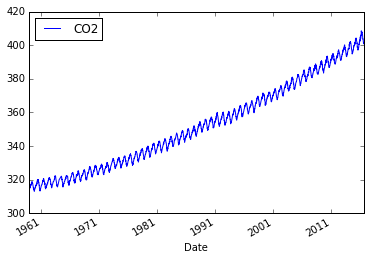

In [2]:
mlo=pd.read_csv('weekly_mlo.csv',skiprows=20,index_col='Date',parse_dates=True)
url='http://scrippsco2.ucsd.edu/sites/default/files/data/in_situ_co2/weekly_mlo.csv'
mlo=pd.read_csv(url,skiprows=21,names=['Date','CO2'],index_col='Date',parse_dates=True)
mlo.plot()

to make this work you will need elapsed time.  This is a little tricky to make and takes a few tricks.  lets run through them.

First you need a start time which is the first index.  But since it is an index you need to use index to get the values out.  to get the values out of an index you type this

In [4]:
mlo.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-17', '1958-05-24',
               '1958-07-05', '1958-07-12', 
               ...
               '2015-06-27', '2015-07-04', '2015-07-11', '2015-07-18',
               '2015-07-25', '2015-08-01', '2015-08-08', '2015-08-15',
               '2015-08-22', '2015-08-29'],
              dtype='datetime64[ns]', name=u'Date', length=2928, freq=None, tz=None)

to get the 0 row which is the start time you use your brackets

In [5]:
mlo.index[0]

Timestamp('1958-03-29 00:00:00')

to get the elapsed you subtract the index from the start time.  This works but gives funn results so THIS WONT WORK YET!

In [7]:
mlo['elapsed'] = (mlo.index.to_series() - mlo.index.to_series()[0])

In [8]:
mlo.head()

,CO2,elapsed
Date,,
1958-03-29,316.19,0 days
1958-04-05,317.31,7 days
1958-04-12,317.69,14 days
1958-04-19,317.58,21 days
1958-04-26,316.48,28 days


In [27]:
mlo.elapsed.dtype

dtype('<m8[ns]')

So we have no idea what that elapsed time type means and we can't do math on it.  So we google stackoverflow and ask for help.  This is not the best post but it helps.  http://stackoverflow.com/questions/24588437/convert-date-to-float-for-linear-regression-on-pandas-data-frame  If you divide a datetime by a timedelta it converts it for you. It is wonky.  And if we divide by 365 days it will put it into years.

In [9]:
mlo['elapsed'] = (mlo.index.to_series() - mlo.index.to_series()[0])/datetime.timedelta(days=365)

In [10]:
mlo.head()

,CO2,elapsed
Date,,
1958-03-29,316.19,0.000000
1958-04-05,317.31,0.019178
1958-04-12,317.69,0.038356
1958-04-19,317.58,0.057534
1958-04-26,316.48,0.076712


so we have an elapsed time.  so now lets compute an S at every time step.

Set your $S_o$ to 3 ppm.  Set R to 1% which is 1/100 which is .01

then plot the S over time.
## Flashback
Make sure to put in decimal places
also exponent is np.exp


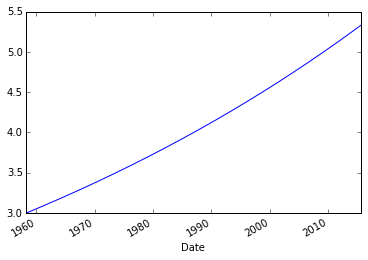

In [11]:
So=3.
R=.01
mlo['S']=So*np.exp(R*mlo.elapsed)
mlo.S.plot()

Now here is the solution for the whole CO2 equation.  
http://www.atmosedu.com/physlets/GlobalPollution/solution.jpg
# $C=C_oe^{-t/\tau}+\frac{S_o}{R+\frac{1}{\tau}}\big[e^{Rt}-e^{-t/\tau}  \big]$

Solve the equation and figure out the best fit parameters for CO2.  How much has CO2 output been growing over the years?  
set tau to 120.0.  Remember this is a simple box model so real life might be slightly different.  

What would CO$_2$ look like now if the growth rate R was halved starting at the beginning of the dataset?  

here are my answers.  Good luck


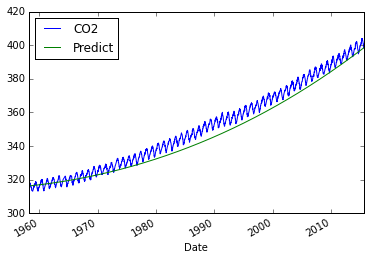

My answer with the R halved.

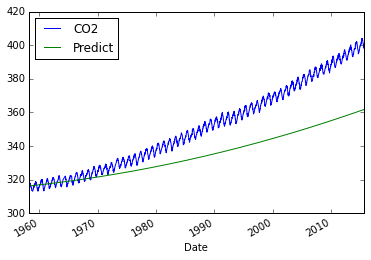